In [1]:
import os
from tqdm import tqdm

## Reading data

In [2]:
messages_dir = '../data/part'
messages = []

for i in range(1, 11):
    messages_part = []
    for message_filename in os.listdir(messages_dir + str(i)):
        message_file = open(messages_dir + str(i) + "/" + message_filename, "r")
        subject = message_file.readline()[9:-1]
        message_file.readline()
        text = message_file.readline()[:-1]
        is_spam = 2 if 'spmsg' in message_filename else 1
        messages_part.append([subject + ' ' + text, is_spam])
    messages.append(messages_part)

## Accuracy score 

In [3]:
def get_accuracy_score(y_true, y_predicted):
    return sum(1 if y_true_i == y_predicted_i else 0 for y_true_i, y_predicted_i in zip(y_true, y_predicted)) / len(y_true)

## Cross Validation

In [4]:
import sys
sys.path.append('../../../cf')
from bayes_F import BayesClassifier 

In [5]:
from collections import Counter 

def most_frequent(l, count): 
    occurence_count = Counter(l) 
    return [x[0] for x in occurence_count.most_common(count)]

In [32]:
def cross_validate(messages, classifier_params):
    scores = []
    for i in range(len(messages)):
        test = messages[i]
        train = messages[:i] + messages[i + 1:]
        X_train = []
        y_train = []
        for messages_part in train:
            for message in messages_part:
                X_train.append(most_frequent(message[0].split(), 25))
                y_train.append(message[1])
        classifier = BayesClassifier(*classifier_params)
        classifier.fit(X_train, y_train)
        y_true = []
        y_predicted = []
        for message in test:
            X_test = message[0].split()
            X_test = most_frequent(X_test, 25)
            y_test = message[1]
            y_true.append(y_test)
            y_predicted.append(classifier.predict(X_test)[0])
        scores.append(get_accuracy_score(y_true, y_predicted))
    return sum(scores) / len(scores)

## Hyperparameter Optimization

In [7]:
def hyperparameter_optimization():
    best_accuracy_score = -1
    best_params = None
    for alpha in [1e-5, 1e-2]:
        for gram_len in [1, 2, 3]:
            accuracy_score = cross_validate(messages, [alpha, gram_len, [1, 1]])
            if best_accuracy_score < accuracy_score:
                best_accuracy_score = accuracy_score
                best_params = [alpha, gram_len, [1, 1]]
    print('Best accuracy score is {0} for params {1}'.format(best_accuracy_score, best_params))
    return best_accuracy_score, best_params

## Model analysis

In [33]:
hyperparameter_optimization()

Best accuracy score is 0.9770642201834863 for params [0.01, 1, [1, 1]]


(0.9770642201834863, [0.01, 1, [1, 1]])

## RocCurve

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [10]:
from bayes_F import BayesClassifier 

In [11]:
classifier = BayesClassifier(0.01, 1, [1, 1])
X_train = []
y_train = []
for messages_part in messages:
    for message in messages_part:
        X_train.append(message[0].split())
        y_train.append(message[1])
classifier.fit(X_train, y_train)
y_pred_probabilities = []
for X in X_train:
    p1, p2 = classifier.predict(X)[1:]
    y_pred_probabilities.append([p1, p2])

../../../cf\bayes_F.py:60: RuntimeWarning: overflow encountered in exp
  p2 = 1 / (1 + np.exp(lp1 - lp2))


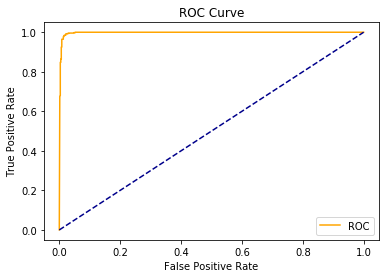

In [20]:
y_true = [y_i - 1 for y_i in y_train]
plot_roc_curve(y_true, [y[1] for y in y_pred_probabilities])

## No FalsePositive

In [41]:
from sklearn.metrics import confusion_matrix
accuracy = []
power = 1
fp = -1
while fp != 0:
    classifier = BayesClassifier(0.01, 1, [10 ** power, 1])
    X_train = []
    y_train = []
    for messages_part in messages[:-1]:
        for message in messages_part:
            X_train.append(most_frequent(message[0].split(), 25))
            y_train.append(message[1])
            
    X_test = []
    y_test = []
    for message in messages[-1]:
        
        X_test.append(most_frequent(message[0].split(), 25))
        y_test.append(message[1])
    classifier.fit(X_train, y_train)
    y_pred = []
    for X in X_test:
        pred = classifier.predict(X)[0]
        y_pred.append(pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy.append(get_accuracy_score(y_test, y_pred))
    print("%2d: TN = %3d, FP = %2d, FN = %2d, TP = %3d" % (power, tn, fp, fn, tp))
    power += 1

 1: TN =  60, FP =  1, FN =  3, TP =  45
 2: TN =  60, FP =  1, FN =  3, TP =  45
 3: TN =  61, FP =  0, FN =  3, TP =  45


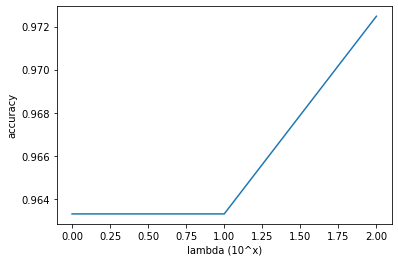

In [42]:
plt.plot(range(0, power - 1), accuracy)
plt.xlabel('lambda (10^x)')
plt.ylabel('accuracy')
plt.show()